# Project 3, Logistic Regression Implementation


# 1. Implmenting the logistic regression classifier without using sk-learn.
# 2. Binary classifier required
# 3. BGD, SGD or Mini-batch GD
# 4. L2 regularization
# 5. Classifier evaluation required
# 6. Compare your implementation with Sk-learn regressor.

## Idea：识别一张图片是否有猫
### 数据集
- 采用H5存储数据集
- 训练集的数量: m_train = 209
- 测试集的数量 : m_test = 50

### 本模型准确性
- bgd训练集准确性： 0.9904306220095693
- bgd测试集准确性： 0.7

- sgd训练集准确性： 1.0
- sgd测试集准确性： 0.72

- mbgd训练集准确性： 1.0
- mbgd测试集准确性： 0.7

### sklearn 库准确率
- 训练集准确性： 1.0
- 测试集准确性： 0.72

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math

In [2]:
# 加载H5数据集
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # 训练集特征
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # 训练集标签

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # 测试集特征
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # 测试集标签
    
    classes = np.array(test_dataset["list_classes"][:]) # ['non-cat', 'cat']

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
# 数据集展示
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = load_dataset()

m_train = train_set_y.shape[1]     #训练集里图片的数量。
m_test = test_set_y.shape[1]       #测试集里图片的数量。
num_px = train_set_x_orig.shape[1] #训练、测试集里面的图片的宽度和高度（均为64x64）。

print ("训练集的数量: m_train = " + str(m_train))
print ("测试集的数量 : m_test = " + str(m_test))
print ("每张图片的宽/高 : num_px = " + str(num_px))
print ("每张图片的大小 : (" + str(num_px) + ", " + str(num_px) + ", 3)")

训练集的数量: m_train = 209
测试集的数量 : m_test = 50
每张图片的宽/高 : num_px = 64
每张图片的大小 : (64, 64, 3)


In [4]:
# 将训练集的维度降低并转置。
x_train = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
y_train = train_set_y
print("测试集维数:", x_train.shape)
print("测试集标签维数:", y_train.shape)


# 将测试集的维度降低并转置。
x_test = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
y_test = test_set_y
print("训练集维数:", x_test.shape)
print("训练集标签维数:", y_test.shape)


# 数据标准化，255为RGB最大值
x_train = x_train / 255
x_test = x_test / 255

测试集维数: (12288, 209)
测试集标签维数: (1, 209)
训练集维数: (12288, 50)
训练集标签维数: (1, 50)


**梯度下降数学理论公式**:

对每个样本 $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

成本函数:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$

In [5]:
# 梯度下降激活函数使用Sigmoid
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [6]:
# 0集初始化
def initialize_with_zeros(dim):
    w = np.zeros(shape = (dim, 1))
    b = 0
    return (w , b)

In [7]:
# mini_batches获取
def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
    np.random.seed(seed) #指定随机种子
    m = X.shape[1]
    mini_batches = []
    
    #第一步：打乱顺序
    permutation = list(np.random.permutation(m)) #它会返回一个长度为m的随机数组，且里面的数是0到m-1
    shuffled_X = X[:,permutation]   #将每一列的数据按permutation的顺序来重新排列。
    shuffled_Y = Y[:,permutation].reshape((1,m))


    #第二步，分割
    num_complete_minibatches = math.floor(m / mini_batch_size) #把你的训练集分割成多少份,请注意，如果值是99.99，那么返回值是99，剩下的0.99会被舍弃
    for k in range(0,num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k * mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k * mini_batch_size:(k+1)*mini_batch_size]
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        #获取最后剩余的部分
        mini_batch_X = shuffled_X[:,mini_batch_size * num_complete_minibatches:]
        mini_batch_Y = shuffled_Y[:,mini_batch_size * num_complete_minibatches:]
        
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches


In [8]:
# 一次传播迭代
def propagate(w, b, X, Y):
    m = X.shape[1]

    # 1. 前向传播，根据激活函数计算激活值
    A = sigmoid(np.dot(w.T,X) + b) 
    # 成本计算
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))

    # 2. 后向传播，梯度下降计算
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)

    cost = np.squeeze(cost)

    # 保存dw,db起来。
    grads = {
                "dw": dw,
                "db": db
             }
    return (grads , cost)

## 4. L2 regularization required for the implementation.

In [9]:
# 一次传播迭代， 加入L2正则化
def propagate_L2(w, b, X, Y, r):
    m = X.shape[1]

    # 根据激活函数计算激活值
    A = sigmoid(np.dot(w.T,X) + b) 
    # 成本计算 L2范式
    cost = (- 1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A))) + r/(2*m) * np.linalg.norm(w, ord=2) 

    # 梯度下降计算
    dw = (1 / m) * np.dot(X, (A - Y).T) + r/m*w
    db = (1 / m) * np.sum(A - Y)

    cost = np.squeeze(cost)

    # 保存dw,db起来。
    grads = {
                "dw": dw,
                "db": db
             }
    return (grads , cost)

## 3. BGD, SGD or Mini-batch GD实现


In [10]:
# 梯度下降更新 w, b
def optimize(w , b , X , Y , num_iterations , learning_rate , print_cost = False
             , gd = 'bgd',mini_batch_size = 64):

    costs = []
    m = X.shape[1]
    seed = 10 #随机种子
    for i in range(num_iterations):
        # BGD实现
        if gd =='bgd':
            # 一次迭代
            #grads, cost = propagate(w, b, X, Y)
            grads, cost = propagate_L2(w, b, X, Y, 0.5)

            dw = grads["dw"]
            db = grads["db"]

            # 迭代dw,db
            w = w - learning_rate * dw
            b = b - learning_rate * db
            
        # SGD实现
        elif gd == "sgd":
            for j in range(0, m):  # 每次训练一个样本
                grads, cost = propagate(w, b, X[:,j].reshape(-1, 1), Y[:,j].reshape(-1, 1))

                dw = grads["dw"]
                db = grads["db"]

                # 迭代dw,db
                w = w - learning_rate * dw
                b = b - learning_rate * db
                
        # Mini-batch GD实现
        elif gd == "mbgd":
            seed = seed + 1
            minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
            for minibatch in minibatches:
                (minibatch_X,minibatch_Y) = minibatch
                grads, cost = propagate(w, b, minibatch_X, minibatch_Y)

                dw = grads["dw"]
                db = grads["db"]

                # 迭代dw,db
                w = w - learning_rate * dw
                b = b - learning_rate * db

        # 记录成本,查看是否下降
        if i % 100 == 0:
            costs.append(cost)
        # 打印成本数据
        if (print_cost) and (i % 100 == 0):
            print("迭代的次数: %i ， 成本值： %f" % (i,cost))

    params  = {
                "w" : w,
                "b" : b }
    grads = {
            "dw": dw,
            "db": db } 
    return (params , grads , costs)

### 预测

In [11]:
# 使用训练好的模型进行预测
def predict(w , b , X ):
    m  = X.shape[1] #图片的数量
    Y_prediction = np.zeros((1,m)) 
    w = w.reshape(X.shape[0],1)

    A = sigmoid(np.dot(w.T , X) + b)
    for i in range(A.shape[1]):
        Y_prediction[0,i] = 1 if A[0,i] > 0.5 else 0

    return Y_prediction

## 5. classifier evaluation required.

In [12]:
# 准确率评估
def accuracy(Y_prediction, Y):
    return 1 - np.mean(np.abs(Y_prediction - Y))

### 模型整合

In [13]:
# 训练模型，整合各个步骤
def model(X_train , Y_train , X_test , Y_test , num_iterations = 2000 , learning_rate = 0.5 , 
          print_cost = False, gd = 'bgd',mini_batch_size = 64):
    # 初始化 w, b
    w , b = initialize_with_zeros(X_train.shape[0])
    # 迭代求解 w, b
    parameters , grads , costs = optimize(w , b , X_train , Y_train, num_iterations, learning_rate , 
                                          print_cost, gd)

    w , b = parameters["w"] , parameters["b"]

    # 预测
    Y_prediction_train = predict(w , b, X_train)
    Y_prediction_test = predict(w , b, X_test)

    d = {
            "costs" : costs,
            "Y_prediction_test" : Y_prediction_test,
            "Y_prediciton_train" : Y_prediction_train,
            "w" : w,
            "b" : b,
            "learning_rate" : learning_rate,
            "num_iterations" : num_iterations }
    return d

## 模型训练及其损失函数下降曲线

### BGD结果

迭代的次数: 0 ， 成本值： 0.693147
迭代的次数: 100 ， 成本值： 0.584954
迭代的次数: 200 ， 成本值： 0.467852
迭代的次数: 300 ， 成本值： 0.377279
迭代的次数: 400 ， 成本值： 0.332714
迭代的次数: 500 ， 成本值： 0.304774
迭代的次数: 600 ， 成本值： 0.281618
迭代的次数: 700 ， 成本值： 0.262005
迭代的次数: 800 ， 成本值： 0.245117
迭代的次数: 900 ， 成本值： 0.230384
迭代的次数: 1000 ， 成本值： 0.217393
迭代的次数: 1100 ， 成本值： 0.205838
迭代的次数: 1200 ， 成本值： 0.195482
迭代的次数: 1300 ， 成本值： 0.186142
迭代的次数: 1400 ， 成本值： 0.177671
迭代的次数: 1500 ， 成本值： 0.169952
迭代的次数: 1600 ， 成本值： 0.162887
迭代的次数: 1700 ， 成本值： 0.156396
迭代的次数: 1800 ， 成本值： 0.150412
迭代的次数: 1900 ， 成本值： 0.144878


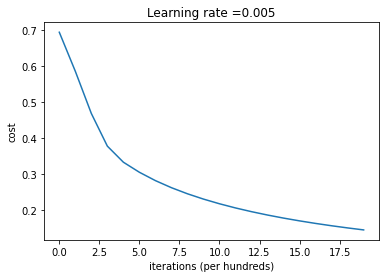

In [14]:
bgd = model(x_train, y_train, x_test, y_test, num_iterations = 2000, learning_rate = 0.005, 
          print_cost = True, gd = "bgd")

# 绘制基本曲线
costs = np.squeeze(bgd['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(bgd["learning_rate"]))
plt.show()

### SGD结果

迭代的次数: 0 ， 成本值： 0.018347
迭代的次数: 100 ， 成本值： 0.043422
迭代的次数: 200 ， 成本值： 0.017345
迭代的次数: 300 ， 成本值： 0.008539
迭代的次数: 400 ， 成本值： 0.005061
迭代的次数: 500 ， 成本值： 0.003625
迭代的次数: 600 ， 成本值： 0.002908
迭代的次数: 700 ， 成本值： 0.002480
迭代的次数: 800 ， 成本值： 0.002194
迭代的次数: 900 ， 成本值： 0.001986
迭代的次数: 1000 ， 成本值： 0.001826
迭代的次数: 1100 ， 成本值： 0.001699
迭代的次数: 1200 ， 成本值： 0.001593
迭代的次数: 1300 ， 成本值： 0.001505
迭代的次数: 1400 ， 成本值： 0.001428
迭代的次数: 1500 ， 成本值： 0.001361
迭代的次数: 1600 ， 成本值： 0.001302
迭代的次数: 1700 ， 成本值： 0.001250
迭代的次数: 1800 ， 成本值： 0.001202
迭代的次数: 1900 ， 成本值： 0.001159


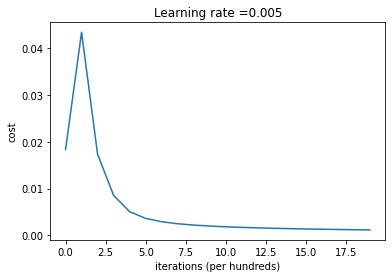

In [15]:
sgd = model(x_train, y_train, x_test, y_test, num_iterations = 2000, learning_rate = 0.005, 
          print_cost = True, gd = "sgd")

# 绘制基本曲线
costs = np.squeeze(sgd['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(sgd["learning_rate"]))
plt.show()

### mbgd结果

迭代的次数: 0 ， 成本值： 0.707157
迭代的次数: 100 ， 成本值： 0.453603
迭代的次数: 200 ， 成本值： 0.239643
迭代的次数: 300 ， 成本值： 0.240844
迭代的次数: 400 ， 成本值： 0.234595
迭代的次数: 500 ， 成本值： 0.120807
迭代的次数: 600 ， 成本值： 0.161384
迭代的次数: 700 ， 成本值： 0.070667
迭代的次数: 800 ， 成本值： 0.086985
迭代的次数: 900 ， 成本值： 0.101530
迭代的次数: 1000 ， 成本值： 0.094890
迭代的次数: 1100 ， 成本值： 0.067584
迭代的次数: 1200 ， 成本值： 0.077184
迭代的次数: 1300 ， 成本值： 0.082054
迭代的次数: 1400 ， 成本值： 0.042173
迭代的次数: 1500 ， 成本值： 0.041717
迭代的次数: 1600 ， 成本值： 0.040089
迭代的次数: 1700 ， 成本值： 0.034578
迭代的次数: 1800 ， 成本值： 0.054866
迭代的次数: 1900 ， 成本值： 0.022182


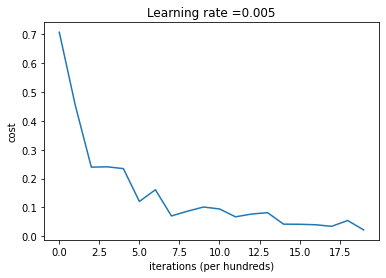

In [16]:
mbgd = model(x_train, y_train, x_test, y_test, num_iterations = 2000, learning_rate = 0.005, 
          print_cost = True, gd = "mbgd")

# 绘制基本曲线
costs = np.squeeze(mbgd['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(mbgd["learning_rate"]))
plt.show()

## 本模型准确性

In [17]:
print("bgd训练集准确性："  , accuracy(bgd['Y_prediciton_train'], y_train))
print("bgd测试集准确性："  , accuracy(bgd['Y_prediction_test'], y_test))
print()
print("sgd训练集准确性："  , accuracy(sgd['Y_prediciton_train'], y_train))
print("sgd测试集准确性："  , accuracy(sgd['Y_prediction_test'], y_test))
print()
print("mbgd训练集准确性："  , accuracy(mbgd['Y_prediciton_train'], y_train))
print("mbgd测试集准确性："  , accuracy(mbgd['Y_prediction_test'], y_test))

bgd训练集准确性： 0.9904306220095693
bgd测试集准确性： 0.7

sgd训练集准确性： 1.0
sgd测试集准确性： 0.72

mbgd训练集准确性： 1.0
mbgd测试集准确性： 0.7


### 实际图形预测

y = 1, 预测这是 a "cat" 图片.


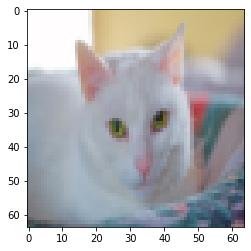

In [18]:
index = 2
plt.imshow(x_test[:,index].reshape((num_px, num_px, 3)))
print("y = " + str(y_test[0,index]) + ", 预测这是 a \"" + 
      classes[int(bgd["Y_prediction_test"][0,index])].decode("utf-8") +  "\" 图片.")

# 6. Compare your implementation with Sk-learn regressor.


In [19]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

In [20]:
# 将训练集的维度降低并转置。
x_train = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
y_train = train_set_y

# 将测试集的维度降低并转置。
x_test = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
y_test = test_set_y



#构建并训练模型
lr = LogisticRegressionCV(fit_intercept=True)
lr.fit(x_train.T, y_train.T)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (s

LogisticRegressionCV()

# sklearn 库准确率

In [21]:
# 模型效果获取
r_train = lr.score(x_train.T, y_train.T)
r_test = lr.score(x_test.T, y_test.T)
# print ("训练集R值：", r_train)
# print("测试集R", r_test)

# print ("参数：",lr.coef_)
# print ("截距：",lr.intercept_)

# sklearn 模型准确率
y_train_pred = lr.predict(x_train.T)
train_accuracy = accuracy_score(y_train.T, y_train_pred)
y_test_pred = lr.predict(x_test.T)
test_accuracy = accuracy_score(y_test.T, y_test_pred)

print("训练集准确性："  , train_accuracy)
print("测试集准确性："  , test_accuracy)


训练集准确性： 1.0
测试集准确性： 0.72
